In [17]:
import pandas as pd 
import matplotlib.pyplot as plt
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer


sentyment - analiza składni, analiza słow kluczowych, określenie emocjonalnego tonu tekstu

1. Preprocessing
- token
- lower letters
- stemming or lemmantization or both
2. feature extracting
- tf-idf
- word2vec
3. Model
- RNN
- LSTM

##### 1. Understand dataset

In [2]:
df_suicide_detection = pd.read_csv('../data/raw/Suicide_Detection.csv', usecols=['text','class'])
df_suicide_detection.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


All of texts are from one forum

In [3]:
df_suicide_detection['class'].value_counts()

class
suicide        116037
non-suicide    116037
Name: count, dtype: int64

Dataset is balanced, there are two class.

In [4]:
df_suicide_detection['length'] = df_suicide_detection['text'].apply(lambda x: len(x.split()))
df_suicide_detection['length'].describe()

count    232074.000000
mean        131.925235
std         217.476787
min           1.000000
25%          26.000000
50%          60.000000
75%         155.000000
max        9684.000000
Name: length, dtype: float64

In [5]:
df_suicide_detection[df_suicide_detection['length']==9684]['text']

217197    Get out of my head.Get out of my head. Get out...
Name: text, dtype: object

In [ ]:
df_suicide_detection['class'] = df_suicide_detection['class'].map({'suicide': 1, 'non-suicide':0})

##### 2. Preprocessing

Lowering of letters

In [6]:
df_suicide_detection['text'] = df_suicide_detection['text'].apply(lambda x: x.lower())
df_suicide_detection['text'].iloc[1]

"am i weird i don't get affected by compliments if it's coming from someone i know irl but i feel really good when internet strangers do it"

Punctuation removal

In [19]:
df_suicide_detection['text'] = df_suicide_detection['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
df_suicide_detection['text'].iloc[1]

['weird',
 'dont',
 'get',
 'affect',
 'compliment',
 'come',
 'someon',
 'know',
 'irl',
 'feel',
 'realli',
 'good',
 'internet',
 'stranger']

Tokenization

In [8]:
def tokenize(text):
    return word_tokenize(text)

df_suicide_detection['text'] = df_suicide_detection['text'].apply(tokenize)
df_suicide_detection['text'].head(1)

0    [ex, wife, threatening, suiciderecently, i, le...
Name: text, dtype: object

Remove stopwords

In [9]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.discard('no')
stop_words.discard('not')
stop_words.discard('don')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
df_suicide_detection['text'] = df_suicide_detection['text'].apply(
    lambda document: [word for word in document if word not in stop_words]
    )
df_suicide_detection['text'].head(1)

0    [ex, wife, threatening, suiciderecently, left,...
Name: text, dtype: object

Remove links, numbers

Stemming

In [11]:
stemmer = PorterStemmer()

In [12]:
df_suicide_detection['text'] = df_suicide_detection['text'].apply(
    lambda document: [stemmer.stem(word) for word in document]
    )    
df_suicide_detection['text'].head(1)

0    [ex, wife, threaten, suiciderec, left, wife, g...
Name: text, dtype: object

In [20]:
df_suicide_detection['text']

0         [ex, wife, threaten, suiciderec, left, wife, g...
1         [weird, dont, get, affect, compliment, come, s...
2         [final, 2020, almost, never, hear, 2020, bad, ...
3                     [need, helpjust, help, im, cri, hard]
4         [’, losthello, name, adam, 16, ’, struggl, yea...
                                ...                        
232069    [dont, like, rock, not, go, get, anyth, go, ht...
232070    [tell, mani, friend, not, lone, everyth, depri...
232071    [pee, probabl, tast, like, salti, tea😏💦‼️, som...
232072    [usual, stuff, find, hereim, not, post, sympat...
232073    [still, havent, beaten, first, boss, hollow, k...
Name: text, Length: 232074, dtype: object

In [44]:
df_suicide_detection

,text,class,length
0,"[ex, wife, threaten, suiciderec, left, wife, g...",1,143
1,"[weird, dont, get, affect, compliment, come, s...",0,27
2,"[final, 2020, almost, never, hear, 2020, bad, ...",0,26
3,"[need, helpjust, help, im, cri, hard]",1,9
4,"[’, losthello, name, adam, 16, ’, struggl, yea...",1,438
...,...,...,...
232069,"[dont, like, rock, not, go, get, anyth, go, ht...",0,19
232070,"[tell, mani, friend, not, lone, everyth, depri...",0,31
232071,"[pee, probabl, tast, like, salti, tea😏💦‼️, som...",0,14
232072,"[usual, stuff, find, hereim, not, post, sympat...",1,364


##### 3. Vectorization

In [34]:
vectorizer = TfidfVectorizer()
df_suicide_detection['text'] = df_suicide_detection['text'].apply(lambda x: ' '.join(x))
X = vectorizer.fit_transform(df_suicide_detection['text'])
Y = df_suicide_detection['class'].values

##### 4. Frequency analysis

In [57]:
from collections import Counter
import matplotlib.pyplot as plt

In [49]:
data_suicide = df_suicide_detection[df_suicide_detection['class'] == 1]
data_non_suicide = df_suicide_detection[df_suicide_detection['class'] == 0]

In [53]:
words_suicide = [word for post in data_suicide['text'] for word in post]
words_non_suicide = [word for post in data_non_suicide['text'] for word in post]

In [58]:
word_freq_suicide = Counter(words_suicide)
word_freq_non_suicide = Counter(words_non_suicide)

In [67]:
top_10_words_suicide = word_freq_suicide.most_common(10)
top_10_words_non_suicide = word_freq_non_suicide.most_common(10)

print("Top 10 słów w kategorii 'suicide':\n", top_10_words_suicide)
print("Top 10 słów w kategorii 'non-suicide':\n", top_10_words_non_suicide)

Top 10 słów w kategorii 'suicide':
 [('’', 245210), ('im', 213445), ('want', 160609), ('feel', 149613), ('dont', 139934), ('like', 137343), ('not', 135528), ('know', 116454), ('get', 115991), ('life', 111408)]
Top 10 słów w kategorii 'non-suicide':
 [('’', 98048), ('like', 54338), ('filler', 54181), ('\u200d', 45185), ('im', 39520), ('not', 35140), ('get', 32387), ('fuck', 30351), ('want', 27830), ('know', 26686)]


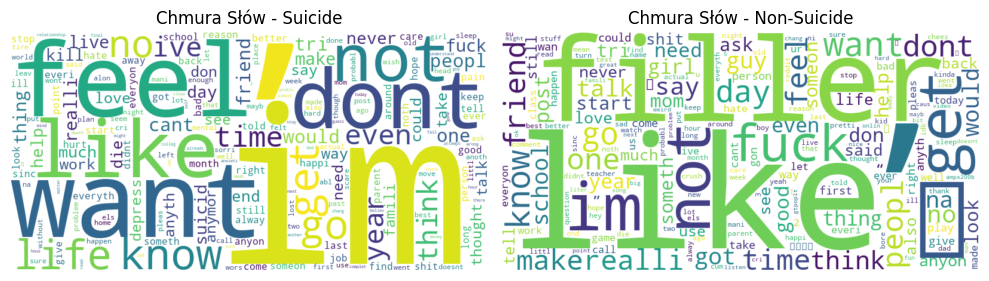

In [70]:
from wordcloud import WordCloud

# Tworzenie chmur słów dla obu kategorii
wordcloud_suicide = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_suicide)
wordcloud_non_suicide = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_non_suicide)

# Wyświetlenie chmur słów
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_suicide, interpolation='bilinear')
plt.title('Chmura Słów - Suicide')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_suicide, interpolation='bilinear')
plt.title('Chmura Słów - Non-Suicide')
plt.axis('off')

plt.tight_layout()
plt.show()

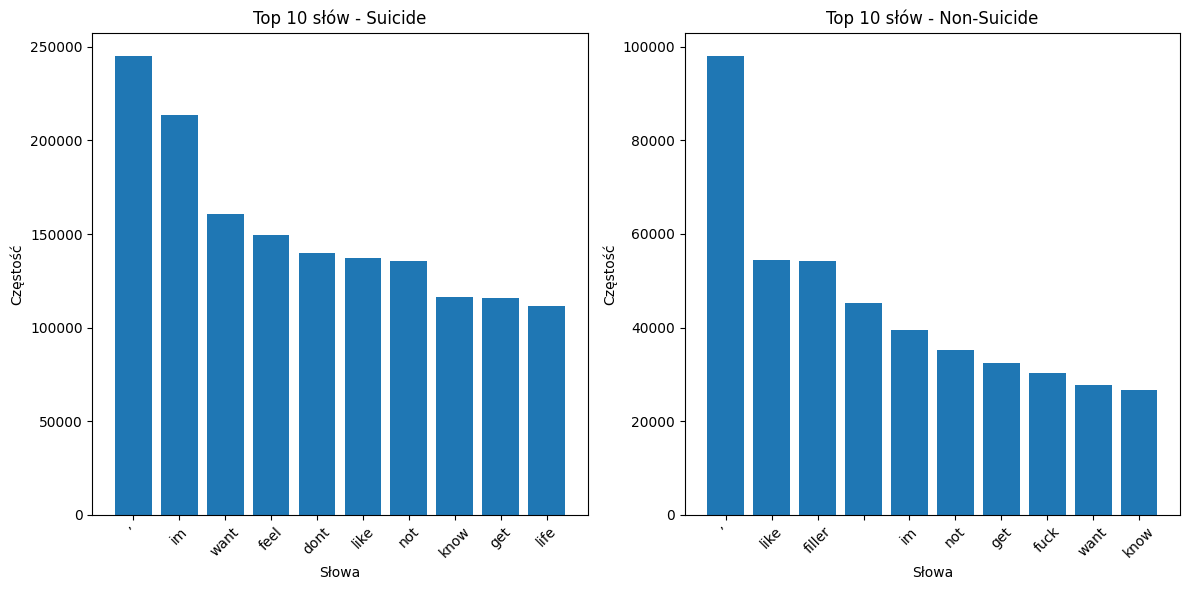

In [69]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(*zip(*top_10_words_suicide))
plt.title('Top 10 słów - Suicide')
plt.xlabel('Słowa')
plt.ylabel('Częstość')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(*zip(*top_10_words_non_suicide))
plt.title('Top 10 słów - Non-Suicide')
plt.xlabel('Słowa')
plt.ylabel('Częstość')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

##### 5. Analysis of Length

In [64]:
print("Length og suicide post: \n",data_suicide['length'].describe())
print("Length of non-suicide post:\n",data_non_suicide['length'].describe())

Length og suicide post: 
 count    116037.000000
mean        202.662168
std         255.309193
min           1.000000
25%          60.000000
50%         127.000000
75%         251.000000
max        9684.000000
Name: length, dtype: float64
Length of non-suicide post:
 count    116037.000000
mean         61.188302
std         139.292553
min           2.000000
25%          19.000000
50%          31.000000
75%          60.000000
max        8220.000000
Name: length, dtype: float64


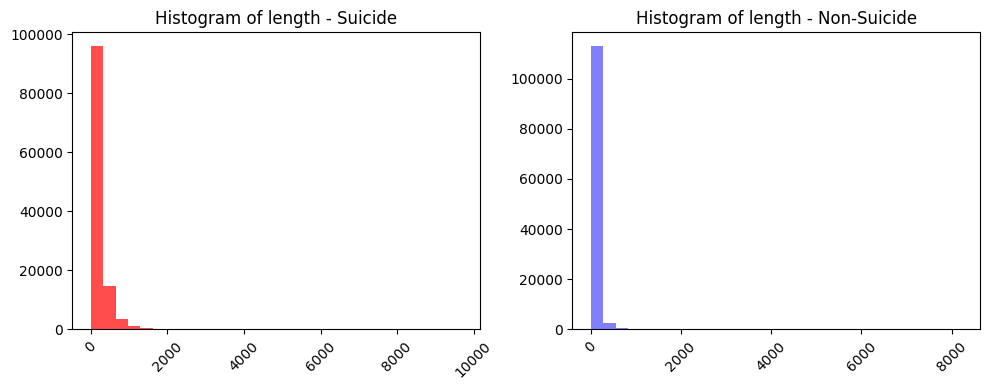

In [74]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(data_suicide['length'],bins=30, alpha=0.7, color='red', label='Suicide')
plt.title('Histogram of length - Suicide')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.hist(data_non_suicide['length'], bins=30, alpha=0.5, color='blue', label='Non-Suicide')
plt.title('Histogram of length - Non-Suicide')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

##### 6. Thematic Analysis

Sentiment Analysis

Analiza Asocjacyjna

Analiza wizualna i interaktywna